In [24]:
import os
import cv2
import pandas as pd
import numpy as np
from math import*
from decimal import Decimal
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from expects import (
    be_true,
    equal,
    expect
)
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [15]:
df=pd.read_csv('new_training_set.csv')
df.rename(columns={'Unnamed: 0': 'pair_index'}, inplace=True)
df.head()

,pair_index,title_1,image_1,title_2,image_2,Label
0,0,Johnson’s ® Top to Toe Hair & Body Bath 500ml,fdff8b9b8229da091dd7d070aae05f81.jpg,Johnson's cottontouch top to toe hair & body b...,41e191742760932598c7bd201e5dad47.jpg,0
1,1,Sandal Humble,906cc44f0be72d4e767669b5b63e3a17.jpg,Sandal Humble Glass - Glanzton,7a556b836bfdd08ea592216440524a34.jpg,0
2,2,PROMO LIKUID LIKUIT LIQUIT BABY POD LIQUID SAL...,475c26635de18b9f93032400732ff336.jpg,Voporizer Liquit - Likuit - Likuid - Liquid Pr...,ace93bec689f3f1565800c500a8341fa.jpg,0
3,3,6 Pasang / Set Anting Tusuk Bentuk Lingkaran A...,e630997f6217555d6026547ad1c15f0b.jpg,Subei 6 Pasang / Set Anting Tusuk Boho Bohemia...,31abbc176b09f5bd1728cfc3ecbbfb9c.jpg,0
4,4,ROREC NATURAL SKIN CARE MASK ROREC SHEET MASK ...,a27d11700a7902febd039dc3a96f10f2.jpg,Rorec 86 Natural Skin Care Shert Mask All Variant,813ad9dd638c10f1765db9dde20c9e42.jpg,1


In [16]:
df['mse_noise']=0
df['ssim_noise']=0

In [17]:
df

,pair_index,title_1,image_1,title_2,image_2,Label,mse_noise,ssim_noise
0,0,Johnson’s ® Top to Toe Hair & Body Bath 500ml,fdff8b9b8229da091dd7d070aae05f81.jpg,Johnson's cottontouch top to toe hair & body b...,41e191742760932598c7bd201e5dad47.jpg,0,0,0
1,1,Sandal Humble,906cc44f0be72d4e767669b5b63e3a17.jpg,Sandal Humble Glass - Glanzton,7a556b836bfdd08ea592216440524a34.jpg,0,0,0
2,2,PROMO LIKUID LIKUIT LIQUIT BABY POD LIQUID SAL...,475c26635de18b9f93032400732ff336.jpg,Voporizer Liquit - Likuit - Likuid - Liquid Pr...,ace93bec689f3f1565800c500a8341fa.jpg,0,0,0
3,3,6 Pasang / Set Anting Tusuk Bentuk Lingkaran A...,e630997f6217555d6026547ad1c15f0b.jpg,Subei 6 Pasang / Set Anting Tusuk Boho Bohemia...,31abbc176b09f5bd1728cfc3ecbbfb9c.jpg,0,0,0
4,4,ROREC NATURAL SKIN CARE MASK ROREC SHEET MASK ...,a27d11700a7902febd039dc3a96f10f2.jpg,Rorec 86 Natural Skin Care Shert Mask All Variant,813ad9dd638c10f1765db9dde20c9e42.jpg,1,0,0
...,...,...,...,...,...,...,...,...
10176,10176,[Bayar Di Tempat]O.TWO.O Lipstick Matte 12 War...,08f5ba211a48e9b66bbf0d0105272efb.jpg,O.TWO.O Lipstick Matte 12 Warna (2 in 1),08f5ba211a48e9b66bbf0d0105272efb.jpg,1,0,0
10177,10177,Baso Aci JELETOT INTANS Gurih Khas Kota Garut,855daa89bf4f31cec0f40b144cdb283e.jpg,Baso Aci Instan Khas Garut Enak Gurih..,ffad7f79772f4e482f420591848cd69e.jpg,0,0,0
10178,10178,MINYAK KUTUS KUTUS ASLI BALI,9525365b5b15af5855abf9daf03da8b4.jpg,Minyak Kutus Kutus Tamba Waras 100ml,7098a9638b9ad66fb8a7912201ec3d82.jpg,1,0,0
10179,10179,[1KG 13PCS] ❤ MiniMamy ❤ Baju Jumper Pendek Ka...,a245f49fdc9a03655d98e6a22a89cb7d.jpg,[1KG 13PCS] ❤ Kiddikiddo❤ Baju Jumper Kaos Pen...,ea3e2af55a4ebcdb61bfb9f5da56d1bb.jpg,0,0,0


In [18]:
for i in range(len(df)):
    image_1=cv2.imread('training_img/training_img/'+df.loc[i,'image_1'], cv2.COLOR_BGR2GRAY)
    image_2=cv2.imread('training_img/training_img/'+df.loc[i,'image_2'], cv2.COLOR_BGR2GRAY)
    noise = np.ones_like(image_2) * 0.2 * (image_2.max() - image_2.min())
    noise[np.random.random(size=noise.shape) > 0.5] *= -1
    image_2 = image_2 + abs(noise)
    
    image_2=cv2.resize(image_2,(25,25))
    image_1=cv2.resize(image_1,(25,25))    


    df.loc[i,'mse_noise'] = mean_squared_error(image_1, image_2)
    df.loc[i,'ssim_noise'] = ssim(image_1, image_2, data_range=image_2.max() - image_2.min(), multichannel=True)

Label
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: ssim_noise, dtype: object

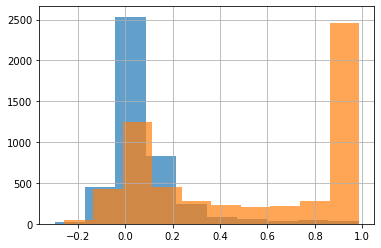

In [19]:
df.ssim_noise.groupby(df['Label']).hist(alpha=0.7)

In [20]:
df.dropna(inplace=True)

In [22]:
X_final=df['ssim_noise'].values.reshape(-1,1)
y_final=df['Label'].values

In [25]:
skf_final = StratifiedKFold(n_splits = 5, shuffle =True, random_state = 2)
for train_index, test_index in skf_final.split(X_final, y_final):
  X_train_final, y_train_final = X_final[train_index], y_final[train_index]
  X_test_final, y_test_final = X_final[test_index], y_final[test_index]

In [26]:
predictmodel1 = DecisionTreeClassifier()
predictmodel1.fit(X_train_final, y_train_final)
y_pred_final1 = predictmodel1.predict(X_test_final)
print('Accuracy: %.2f' % accuracy_score(y_test_final, y_pred_final1))
print('Fscore: %.2f' % f1_score(y_test_final, y_pred_final1))

Accuracy: 0.67
Fscore: 0.71


In [27]:
predictmodel2 = LogisticRegression()
predictmodel2.fit(X_train_final, y_train_final)
y_pred_final2 = predictmodel2.predict(X_test_final)
print('Accuracy: %.2f' % accuracy_score(y_test_final, y_pred_final2))
print('Fscore: %.2f' % f1_score(y_test_final, y_pred_final2))

Accuracy: 0.75
Fscore: 0.75


In [28]:
predictmodel3 = GaussianNB()
predictmodel3.fit(X_train_final, y_train_final)
y_pred_final3 = predictmodel3.predict(X_test_final)
print('Accuracy: %.2f' % accuracy_score(y_test_final, y_pred_final3))
print('Fscore: %.2f' % f1_score(y_test_final, y_pred_final3))

Accuracy: 0.75
Fscore: 0.74


In [29]:
predictmodel4 = SVC()
predictmodel4.fit(X_train_final, y_train_final)
y_pred_final4 = predictmodel4.predict(X_test_final)
print('Accuracy: %.2f' % accuracy_score(y_test_final, y_pred_final4))
print('Fscore: %.2f' % f1_score(y_test_final, y_pred_final4))

Accuracy: 0.75
Fscore: 0.74
